#Set Up

In [ ]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.8 MB/s eta 0:00:00


In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import matplotlib.pyplot as plt
import numpy as np

# Directory Creation

  Creating a directory to set the path of Datasets of Weeds


In [ ]:
HOME = os.getcwd()
print(HOME)

!mkdir -p {HOME}/data

!wget /content/drive/MyDrive/Weeds_new.zip

!unzip -q -d {HOME}/data /content/drive/MyDrive/Weeds_new.zip

/content
/content/drive/MyDrive/Weeds_new.zip: Scheme missing.


# Data loading

In [ ]:
home_dir = os.path.expanduser("~")
train_image_dir = os.path.join(home_dir, '/content/data/Weeds_new/train/')
val_image_dir = os.path.join(home_dir, '/content/data/Weeds_new/test/')




def xml_files_fun(img_dir):
  xml_files = sorted([
        os.path.join(img_dir, file_name)
        for file_name in os.listdir(img_dir)
        if file_name.endswith(".xml")
    ]
  )
  return xml_files

train_xml_files = xml_files_fun(train_image_dir)
test_xml_files = xml_files_fun(val_image_dir)


def jpg_files_fun(image_dir):
  jpg_files = sorted([
        os.path.join(image_dir, file_name)
        for file_name in os.listdir(image_dir)
        if file_name.endswith(".jpg")])
  return jpg_files
train_jpg_files = jpg_files_fun(train_image_dir)
test_jpg_files = jpg_files_fun(val_image_dir)

class_ids = [
    "Weeds"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))


# Parsing the annotations

In [ ]:
def parse_annotation(xml_file,image_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(image_dir, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


train_image_paths = []
test_image_paths = []
train_bbox = []
test_bbox = []
train_classes = []
test_classes = []

for xml_file in tqdm(train_xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file,train_image_dir)
    train_image_paths.append(image_path)
    train_bbox.append(boxes)
    train_classes.append(class_ids)

for xml_file in tqdm(test_xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file,val_image_dir)
    test_image_paths.append(image_path)
    test_bbox.append(boxes)
    test_classes.append(class_ids)

  0%|          | 0/3664 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

In [ ]:
#train
train_bbox = tf.ragged.constant(train_bbox)
train_classes = tf.ragged.constant(train_classes)
train_image_paths = tf.ragged.constant(train_image_paths)

#test
test_bbox = tf.ragged.constant(test_bbox)
test_classes = tf.ragged.constant(test_classes)
test_image_paths = tf.ragged.constant(test_image_paths)

train_data = tf.data.Dataset.from_tensor_slices((train_image_paths, train_classes, train_bbox))
val_data = tf.data.Dataset.from_tensor_slices((test_image_paths, test_classes, test_bbox))

#Splitting data in training and validation data

In [ ]:
train_num_val = int(len(train_xml_files))
test_num_val = int(len(test_xml_files))
# # Split the dataset into train and validation sets
val_data = val_data.take(test_num_val)
train_data = train_data.take(train_num_val)

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


#Data Augmentation

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(416, 416),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xyxy"
        ),
    ]
)

#Creating Training Dataset

In [ ]:
BATCH_SIZE = 4
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)


#Creating Validation Dataset

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(416, 416),
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

#Visualization

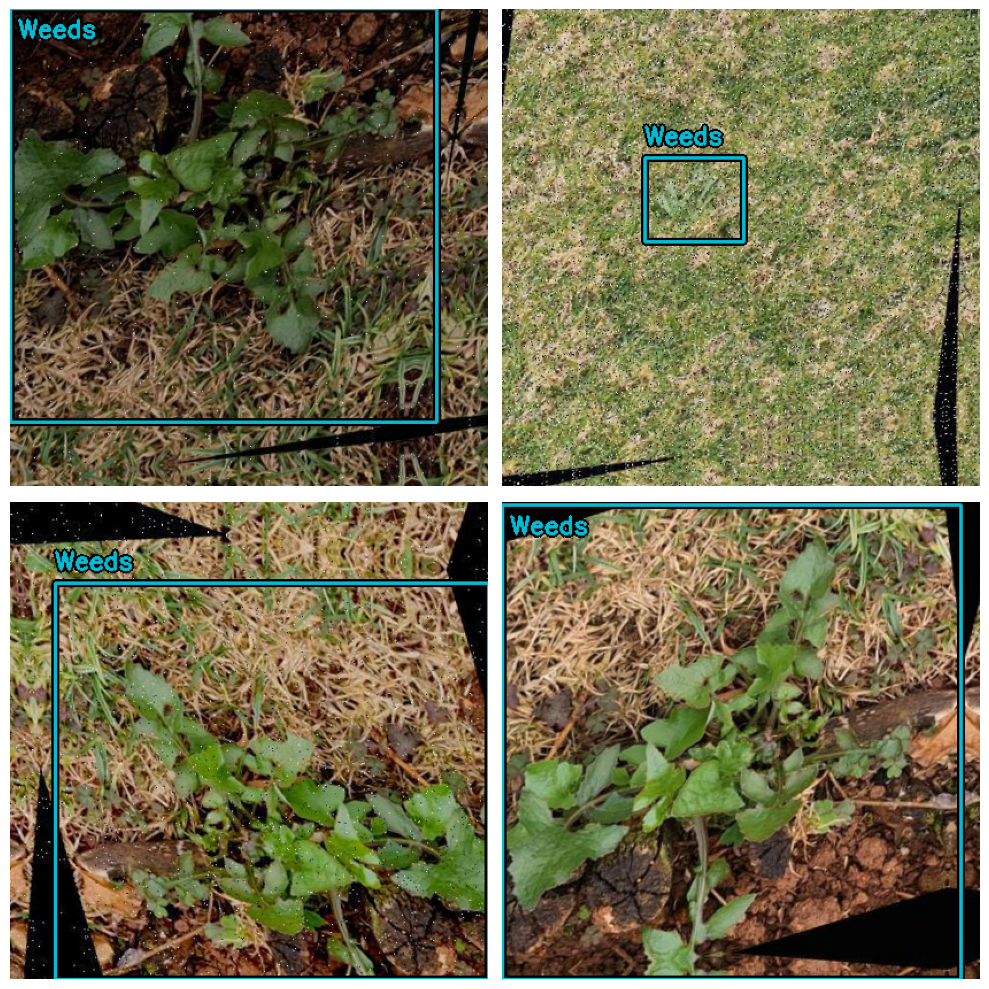

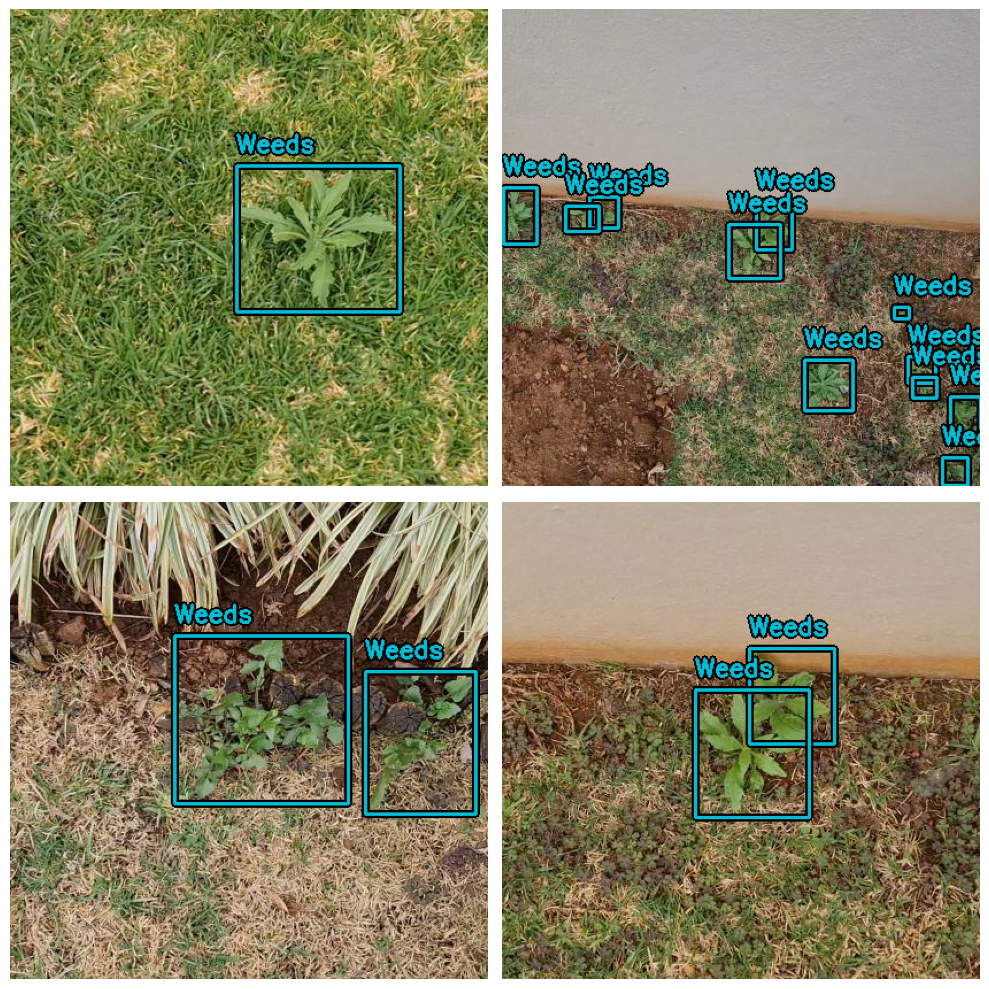

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

#Hyperparameter Optimization

In [ ]:
import keras_tuner
from tensorflow import keras
from keras_cv.models import YOLOV8Backbone, YOLOV8Detector

EPOCH = 5

class YOLOV8HyperModel(keras_tuner.HyperModel):
    def __init__(self, class_mapping):
        self.class_mapping = class_mapping

    def build(self, hp):
        # Define the hyperparameters to tune
        learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
        global_clipnorm = hp.Float("global_clipnorm", min_value=1.0, max_value=10.0)
        backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")
        model = keras_cv.models.RetinaNet(
        num_classes=len(class_ids),
        backbone=backbone,
        bounding_box_format="xyxy",
        )

        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate,
            global_clipnorm=global_clipnorm,
        )
        model.compile(
          classification_loss='focal',box_loss='smoothl1',optimizer=optimizer, jit_compile=False,
        )

        return model

# Define the hypermodel instance
hypermodel = YOLOV8HyperModel(class_mapping=class_ids)

# Set up the BayesianOptimization tuner
tuner = keras_tuner.BayesianOptimization(
    hypermodel=hypermodel,
    objective='val_loss',  # or 'val_accuracy', depending on your metric
    max_trials=3,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=42,
)


# Define the early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


# Start the hyperparameter search
tuner.search(train_ds, validation_data=val_ds, epochs=EPOCH, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 3 Complete [00h 00m 15s]

Best val_loss So Far: 0.6176652312278748
Total elapsed time: 01h 03m 11s


#Best Parameters

In [ ]:
print("learning_rate: ",best_hps.get("learning_rate"))
print("global_clipnorm: ",best_hps.get("global_clipnorm"))

learning_rate:  0.0001681154540009978
global_clipnorm:  3.446878729456817


# Build Model with Optimal hyperparameters

In [ ]:
# learning_rate = best_hps.get("learning_rate")
# global_clipnorm = best_hps.get("global_clipnorm")
learning_rate=  0.0001681154540009978
global_clipnorm=  3.446878729456817
backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")
yolo = keras_cv.models.RetinaNet(
    num_classes=len(class_ids),
    backbone=backbone,
    bounding_box_format="xyxy",

)

optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate,
            global_clipnorm=global_clipnorm,
        )
yolo.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=optimizer,
    jit_compile=False

)




yolo.summary()




Model: "yolov8_detector_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_5 (Functional) │ [(None, None, None,    │     23,561,152 │ input_layer_7[0][0]    │
│                           │ 512), (None, None,     │                │                        │
│                           │ None, 1024), (None,    │                │                        │
│                           │ None, None, 2048)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_4 (Repeat)         │ (None, None, None,     │              0 │ functional_5[0][2]     │
│                           │ 2048)                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_5 (Repeat)         │ (None, None, None,     │              0 │ repeat_4[0][0]         │
│                           │ 2048)                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, None, None,     │              0 │ repeat_5[0][0],        │
│ (Concatenate)             │ 3072)                  │                │ functional_5[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_conv      │ (None, None, None,     │      3,145,728 │ concatenate_12[0][0]   │
│ (Conv2D)                  │ 1024)                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_bn        │ (None, None, None,     │          4,096 │ pa_fpn_p4p5_pre_conv[… │
│ (BatchNormalization)      │ 1024)                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre           │ (None, None, None,     │              0 │ pa_fpn_p4p5_pre_bn[0]… │
│ (Activation)              │ 1024)                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ split_4 (Split)           │ [(None, None, None,    │              0 │ pa_fpn_p4p5_pre[0][0]  │
│                           │ 512), (None, None,     │                │                        │
│                           │ None, 512)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_pad   │ (None, None, None,     │              0 │ split_4[0][1]          │
│ (ZeroPadding2D)           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_conv  │ (None, None, None,     │      2,359,296 │ pa_fpn_p4p5_pre_0_1_p… │
│ (Conv2D)                  │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_bn    │ (None, None, None,     │          2,048 │ pa_fpn_p4p5_pre_0_1_c… │
│ (BatchNormalization)      │ 512)                   │                │                        │
├──────────────────────

 Total params: 140,974,220 (537.77 MB)

 Trainable params: 140,876,556 (537.40 MB)

 Non-trainable params: 97,664 (381.50 KB)

# Check Point to save weights

In [ ]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/cp_weed_detection8_resnet_cv2.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

#Training the model

In [ ]:
history = yolo.fit(train_ds, validation_data=val_ds, epochs=5,callbacks=[cp_callback,early_stopping])


Epoch 1/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 854s 818ms/step - loss: 26.0487 - val_loss: 3.0255
Epoch 2/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 761s 830ms/step - loss: 2.4259 - val_loss: 2.9561
Epoch 3/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 756s 825ms/step - loss: 2.1868 - val_loss: 2.7390
Epoch 4/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 761s 830ms/step - loss: 2.0303 - val_loss: 2.8110
Epoch 5/5
916/916 ━━━━━━━━━━━━━━━━━━━━ 762s 830ms/step - loss: 1.9123 - val_loss: 2.9685


In [ ]:
os.listdir(checkpoint_dir)

['cp_weed_detection8_resnet_cv2.weights.h5']

# Save the model

In [ ]:
yolo.save('/content/drive/MyDrive/checkpoints/weed_detection8_yolov8_resnet_model.keras')

# Evaluation of Online dataset

In [ ]:
results = yolo.evaluate(val_ds)

print(results)

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - loss: 3.0056
2.949042320251465


#Visualize Online dataset Predictions

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = yolo.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


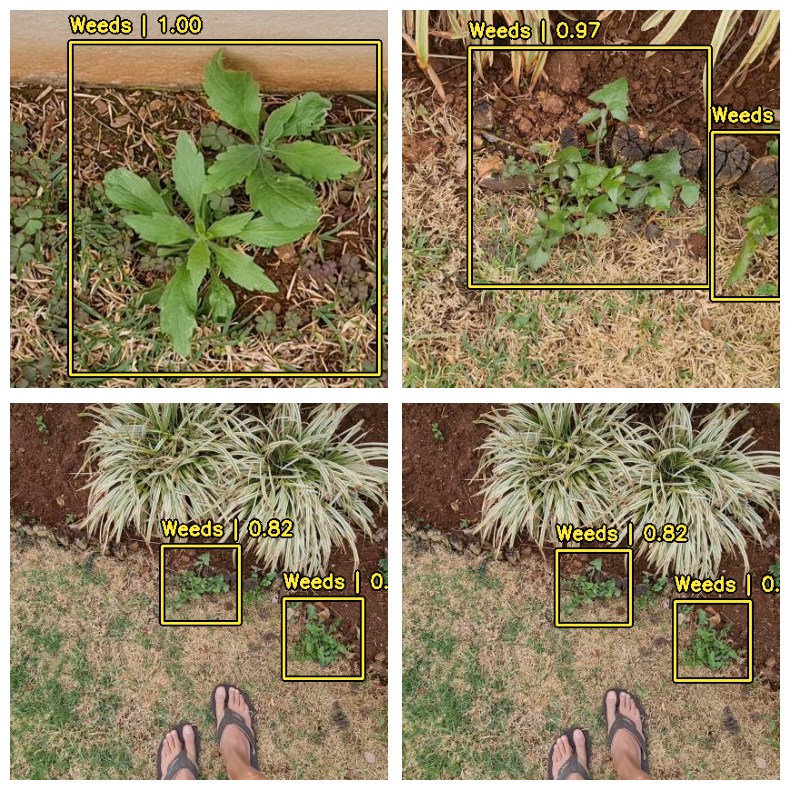

In [ ]:
yolo.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")


#Plot metrics

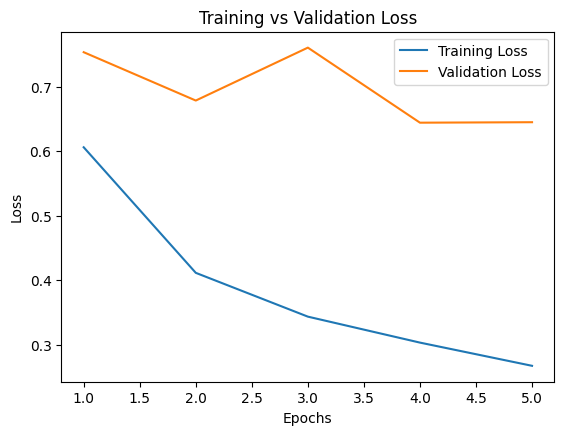

In [ ]:
import matplotlib.pyplot as plt

# Data from the history
data = history.history

epochs = range(1, 6)

plt.figure(figsize=(14, 10))

# Training vs Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, data['loss'], label='Training Loss')
plt.plot(epochs, data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()


#Saved Model

In [ ]:
yolo = tf.keras.models.load_model('/content/drive/MyDrive/checkpoints/weed_detection8_yolov8_resnet_model.keras')


optimizer = keras.optimizers.Adam(
            learning_rate=0.00013292918943162162,
            global_clipnorm=9.556428757689245,
        )
yolo.compile(
    classification_loss='focal',
    box_loss='smoothl1',
    optimizer=optimizer,
    jit_compile=False

)
# Show the model architecture
yolo.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


Model: "retina_net_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)       │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ [(None, None, None,    │     23,561,152 │ images[0][0]           │
│                           │ 512), (None, None,     │                │                        │
│                           │ None, 1024), (None,    │                │                        │
│                           │ None, None, 2048)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_pyramid_2         │ [(None, None, None,    │      7,997,440 │ functional_2[0][0],    │
│ (FeaturePyramid)          │ 256), (None, None,     │                │ functional_2[0][1],    │
│                           │ None, 256), (None,     │                │ functional_2[0][2]     │
│                           │ None, None, 256),      │                │                        │
│                           │ (None, None, None,     │                │                        │
│                           │ 256), (None, None,     │                │                        │
│                           │ None, 256)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ prediction_head_3         │ (None, None, None, 36) │      1,853,220 │ feature_pyramid_2[0][… │
│ (PredictionHead)          │                        │                │ feature_pyramid_2[0][… │
│                           │                        │                │ feature_pyramid_2[0][… │
│                           │                        │                │ feature_pyramid_2[0][… │
│                           │                        │                │ feature_pyramid_2[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ prediction_head_2         │ (None, None, None, 36) │      1,853,220 │ feature_pyramid_2[0][… │
│ (PredictionHead)          │                        │                │ feature_pyramid_2[0][… │
│                           │                        │                │ feature_pyramid_2[0][… │
│                           │                        │                │ feature_pyramid_2[0][… │
│                           │                        │                │ feature_pyramid_2[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_20 (Reshape)      │ (None, None, 4)        │              0 │ prediction_head_3[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_22 (Reshape)      │ (None, None, 4)        │              0 │ prediction_head_3[1][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_24 (Reshape)      │ (None, None, 4)        │              0 │ prediction_head_3[2][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_26 (Reshape)      │ (None, None, 4)        │              0 │ prediction_head_3[3][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_28 (Reshape)      │ (None, None, 4)        │              0 │ prediction_head_3[4][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_21 (Reshape)      │ (None, None, 4)        │              0 │ prediction_head_2[0][… │
├──────────────────────

 Total params: 35,265,032 (134.53 MB)

 Trainable params: 35,211,912 (134.32 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Directory creation to evaulate Ground Truth Dataset

In [ ]:
HOME = os.getcwd()
print(HOME)

!mkdir -p {HOME}/data

!wget /content/drive/MyDrive/weeds_data_live_images.zip

!unzip -q -d {HOME}/data /content/drive/MyDrive/weeds_data_live_images.zip


!wget /content/drive/MyDrive/weeds_data_live.zip

!unzip -q -d {HOME}/data /content/drive/MyDrive/weeds_data_live.zip

/content
/content/drive/MyDrive/weeds_data_live_images.zip: Scheme missing.
/content/drive/MyDrive/weeds_data_live.zip: Scheme missing.


In [ ]:
home_dir = os.path.expanduser("~")
live_dataset_path=os.path.join(home_dir, '/content/data/weeds_data_live_images/')

#Ground Truth Data loading

In [ ]:
live_val_image_dir = os.path.join(home_dir, '/content/data/weeds_data_live_images/train/')

live_xml_files = xml_files_fun(live_val_image_dir)

live_jpg_files = jpg_files_fun(live_val_image_dir)


live_image_paths = []
live_bbox = []
live_classes = []

for xml_file in tqdm(live_xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file,live_val_image_dir)
    live_image_paths.append(image_path)
    live_bbox.append(boxes)
    live_classes.append(class_ids)

live_bbox = tf.ragged.constant(live_bbox)
live_classes = tf.ragged.constant(live_classes)
live_image_paths = tf.ragged.constant(live_image_paths)

live_data = tf.data.Dataset.from_tensor_slices((live_image_paths, live_classes, live_bbox))
live_num_val = int(len(live_xml_files))

live_data = live_data.take(live_num_val)


live_resizing = keras_cv.layers.JitteredResize(
    target_size=(416, 416),
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

live_ds = live_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
live_ds = live_ds.shuffle(BATCH_SIZE * 4)
live_ds = live_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
live_ds = live_ds.map(live_resizing, num_parallel_calls=tf.data.AUTOTUNE)


live_ds = live_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
live_ds = live_ds.prefetch(tf.data.AUTOTUNE)


  0%|          | 0/78 [00:00<?, ?it/s]

# Evaluation of Ground Truth dataset

In [ ]:

live_results = yolo.evaluate(live_ds)

print("Overall evaluation loss of the ground truth dataset: ",live_results)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 1.2964
Overall evaluation loss of the ground truth dataset:  1.3273414373397827


# Vizualizing predictions with Ground truth dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


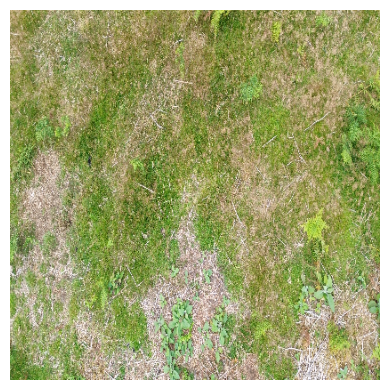

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


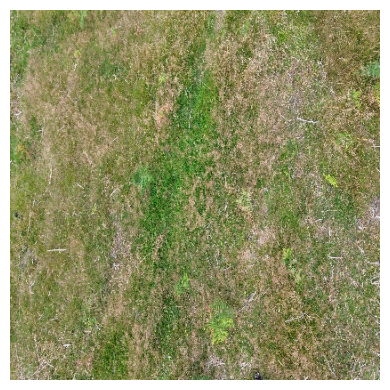

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


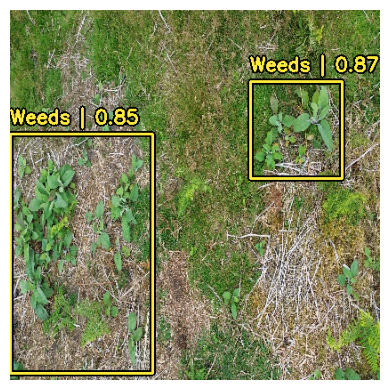

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


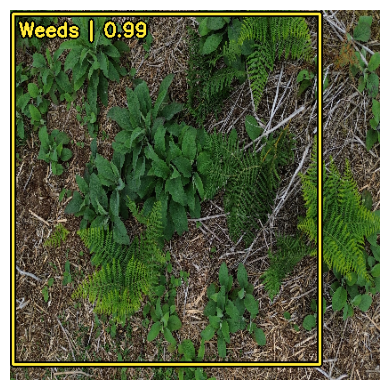

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
Coordinates (xmin, ymin, xmax, ymax): {1: array([], shape=(1, 0), dtype=float64), 2: array([], shape=(1, 0), dtype=float64), 3: array([[[270.91168  ,  80.30702  , 373.8806   , 189.57735  ],
        [  0.5548096, 139.46307  , 160.6167   , 408.23224  ]]],
      dtype=float32), 4: array([[[  3.6573486,   4.267334 , 348.35623  , 398.24518  ]]],
      dtype=float32)}


In [ ]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def visualize_detections(model, image_path, bounding_box_format):
    # Load the image from the specified path
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image to match the model's input requirements
    target_size = tf.constant([416, 416], dtype=tf.int32)
    image_resized = tf.image.resize(image, target_size)
    image_resized = tf.expand_dims(image_resized, axis=0)  # Add batch dimension
    image_resized = tf.cast(image_resized, dtype=tf.float32)  # Ensure the image is in float32 format

    # Get predictions from the model
    y_pred = model.predict(image_resized)
    # Visualize the predictions using the provided function
    visualization.plot_bounding_box_gallery(
        images=image_resized,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

# Function to get a list of random images from a directory
def get_random_images_from_folder(folder_path, num_images):
    # List all files in the folder
    all_files = os.listdir(folder_path)

    # Filter out non-image files (optional)
    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif'))]

    # Randomly select `num_images` from the list of image files
    random_images = random.sample(image_files, num_images)

    # Return the full paths to the randomly selected images
    return [os.path.join(folder_path, img) for img in random_images]

# Assuming yolo model and class_mapping are already defined
yolo.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)


# Folder containing images
image_folder_path = '/content/data/images'

# Get 4 random images from the folder
random_image_paths = get_random_images_from_folder(image_folder_path, 4)

bbox_dict = {}
i=1
# Loop through each image and visualize detections
for image_path in random_image_paths:
    visualize_detections(yolo, image_path=image_path, bounding_box_format="xyxy")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target_size = tf.constant([416,416], dtype=tf.int32)
    image_resized = tf.image.resize(image, target_size)
    image_resized = tf.expand_dims(image_resized, axis=0)  # Add batch dimension
    image_resized = tf.cast(image_resized, dtype=tf.float32)  # Ensure the image is in float32 format
    y_pred = yolo.predict(image_resized)
    boxes = y_pred["boxes"]
    filtered_boxes = np.array([sub_array for sub_array in boxes[0] if not np.all(sub_array == -1)])
    filtered_boxes = np.expand_dims(filtered_boxes, axis=0)
    bbox_dict[i] = filtered_boxes
    i =i+1

print(f"Coordinates (xmin, ymin, xmax, ymax): {bbox_dict}")

#Weed detected GPS locations

In [ ]:
import pandas as pd
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from fractions import Fraction
import random
import os

# Function to extract GPS data from image metadata
def get_image_gps(image_path):
    image = Image.open(image_path)
    exif_data = image._getexif()
    if not exif_data:
        return None

    gps_info = {}

    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag)
        if tag_name == "GPSInfo":
            for key in value:
                decode = GPSTAGS.get(key)
                gps_info[decode] = value[key]
    return gps_info

# Function to convert GPS coordinates to decimal degrees
def convert_to_decimal(degrees, minutes, seconds, direction):
    # Convert the fractions to floats
    degrees = float(Fraction(degrees))
    minutes = float(Fraction(minutes))
    seconds = float(Fraction(seconds))

    # Perform the conversion to decimal degrees
    decimal = degrees + minutes / 60 + seconds / 3600

    # Adjust for direction
    if direction in ['S', 'W']:
        decimal = -decimal

    return decimal

# Function to extract latitude and longitude from GPS data
def extract_lat_lon(gps_data):
    if not gps_data:
        return None, None

    # Extract the relevant data
    lat_degrees, lat_minutes, lat_seconds = gps_data['GPSLatitude']
    lon_degrees, lon_minutes, lon_seconds = gps_data['GPSLongitude']

    lat_direction = gps_data['GPSLatitudeRef']
    lon_direction = gps_data['GPSLongitudeRef']

    # Convert to decimal
    lat = convert_to_decimal(lat_degrees, lat_minutes, lat_seconds, lat_direction)
    lon = convert_to_decimal(lon_degrees, lon_minutes, lon_seconds, lon_direction)

    return lat, lon


# Function to calculate GPS coordinates based on bounding box and image metadata
def calculate_gps_coordinates(bbox, image_gps, image_dimensions, lat_offset, lon_offset):
    # Unpack the bounding box
    x, y, w, h = bbox
    img_width, img_height = image_dimensions

    # Offset calculation: convert pixel position to GPS coordinates.
    lat = image_gps['lat'] + (y / img_height) * lat_offset
    lon = image_gps['lon'] + (x / img_width) * lon_offset

    return lat, lon


# Example image paths
image_paths = random_image_paths  # replace with actual image paths

# Process each image
for i, image_path in enumerate(image_paths, start=1):
    image_gps = get_image_gps(image_path)
    if image_gps:
        lat, lon = extract_lat_lon(image_gps)
        print(f"Image {i}: {image_path} -> Latitude: {lat}, Longitude: {lon}")
        detected_bboxes = bbox_dict.get(i)
        if detected_bboxes is not None:
            width, height = 4000, 2250  # Replace with actual image dimensions if different
            lat_offset = 0.0001  # Latitude change per pixel
            lon_offset = 0.0001  # Longitude change per pixel

            for bbox in detected_bboxes[0]:  # Iterate over all bounding boxes for the image
                weed_lat, weed_lon = calculate_gps_coordinates(
                    bbox,
                    {'lat': lat, 'lon': lon},
                    (width, height),
                    lat_offset,
                    lon_offset
                )
                print(f"Weed detected at Latitude: {weed_lat}, Longitude: {weed_lon}")
    else:
        print(f"Image {i}: {image_path} -> No GPS data found.")


Image 1: /content/data/images/dji_fly_20240817_123256 PM_447_1723910242623_aeb.JPG -> Latitude: 53.35420791666667, Longitude: -1.6825311944444443
Image 2: /content/data/images/dji_fly_20240817_122714 PM_416_1723910277393_aeb.JPG -> Latitude: 53.35416275, Longitude: -1.6825569444444444
Image 3: /content/data/images/dji_fly_20240817_123852 PM_492_1723910195272_aeb.JPG -> Latitude: 53.35420744444445, Longitude: -1.6825033333333332
Weed detected at Latitude: 53.35421101364543, Longitude: -1.68249656054128
Weed detected at Latitude: 53.35421364280328, Longitude: -1.682503319463094
Image 4: /content/data/images/dji_fly_20240817_123836 PM_478_1723910198158_aeb.JPG -> Latitude: 53.35422058333334, Longitude: -1.6824309722222222
Weed detected at Latitude: 53.354220772992626, Longitude: -1.6824308807885064
